# Data PreProcessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing packagesimport pandas as pd
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Loading csv file
path = r'/content/drive/MyDrive/Data Base/Distance Parameter/S7_D.csv'

df = pd.read_csv(path, skiprows=1, usecols=list(range(4, 29)), names=['Acc_x_knee','Acc_y_knee','Acc_z_knee','Gyro_x_knee','Gyro_y_knee','Gyro_z_knee','Magne_x_knee','Magne_y_knee','Magne_z_knee','Euler_x_knee','Euler_y_knee','Euler_z_knee','Acc_x_hip','Acc_y_hip','Acc_z_hip','Gyro_x_hip','Gyro_y_hip','Gyro_z_hip','Magne_x_hip','Magne_y_hip','Magne_z_hip','Euler_x_hip','Euler_y_hip','Euler_z_hip','Real_Velocity'])

# Standardizing
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare sequences and labels
X_sequences_list = []
y_label_list = []

start_idx = 0
for idx in range(1, len(df)):
    # Check if it's the end of an experiment
    if df['Real_Velocity'].iloc[idx] != df['Real_Velocity'].iloc[idx-1]:
        end_idx = idx
        X_sequences_list.append(df_scaled[start_idx:end_idx])
        y_label_list.append(df_scaled[end_idx, -1])
        start_idx = idx + 1

# Convert lists to arrays if needed (depends on your subsequent processes)
X_sequences = np.array(X_sequences_list)
y_labels = np.array(y_label_list)

print("X_sequences shape:", X_sequences.shape)
print("y_label:", y_labels.shape)


X_sequences shape: (19,)
y_label: (19,)


<ipython-input-3-fd800d2e7672>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_sequences = np.array(X_sequences_list)


## Create train and test subdatasets

In [4]:
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences

# Assuming L is the sequence length you want
L = 1000  # or whatever sequence length you decide upon
num_features = 25  # Assuming each element in a sequence is of length 25

X_train_padded = pad_sequences(X_sequences, maxlen=L, padding='post', truncating='post', dtype='float32')

# Reshaping to add the feature dimension
X_train_padded = X_train_padded.reshape((-1, L, num_features))

print("Padded X_train shape:", X_train_padded.shape)

# Split the sequences and labels into training and test sets
X_train_list, X_test_list, y_train, y_test = train_test_split(X_train_padded, y_labels, test_size=0.2)

print("Train sequences:", len(X_train_list),len(y_train))
print("Test sequences:", len(X_test_list),len(y_test))


Padded X_train shape: (19, 1000, 25)
Train sequences: 15 15
Test sequences: 4 4


## Graphics

<ipython-input-5-0385943ff44f>:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


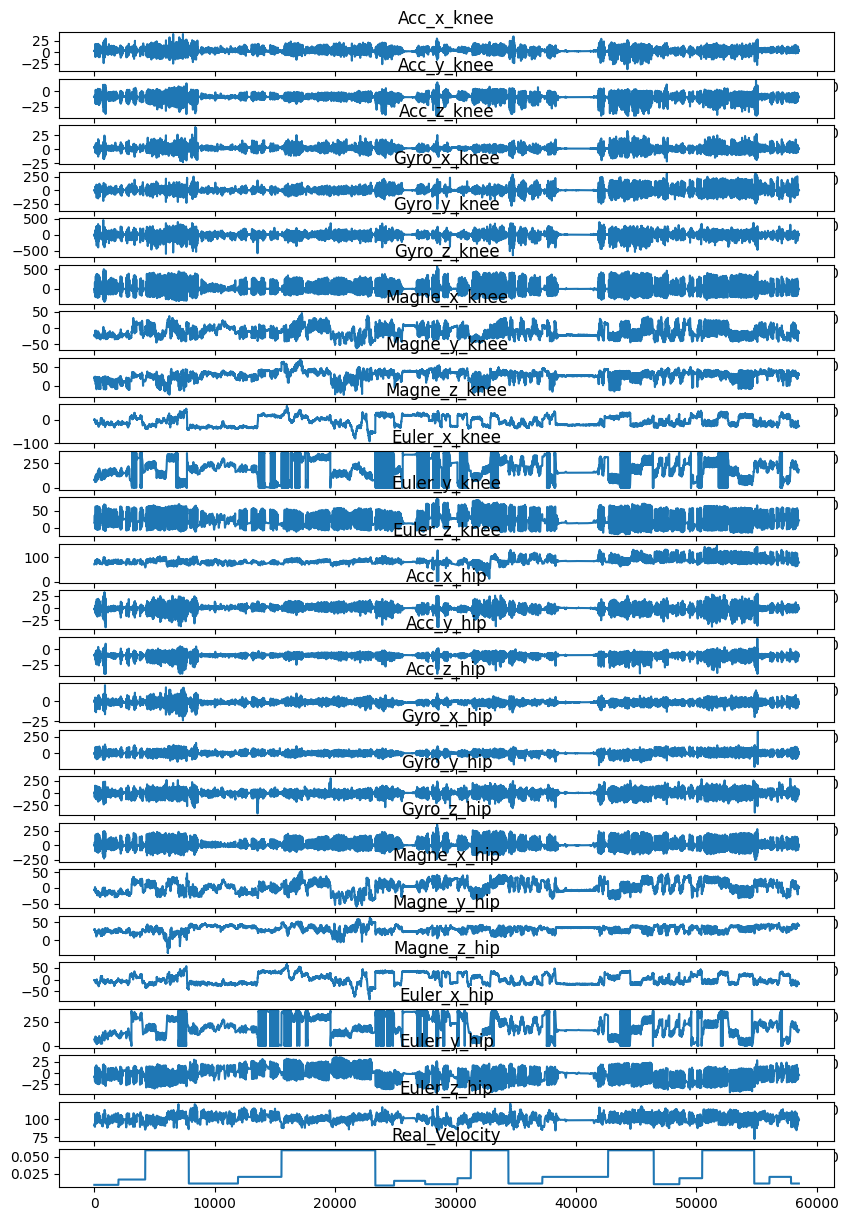

In [5]:
import matplotlib.pyplot as plt

def plot_features(data):
    # Create a new figure with a defined size
    plt.figure(figsize=(10, 15))

    # Loop through each column in data
    for i, column in enumerate(data.columns, 1):
        plt.subplot(len(data.columns), 1, i)
        plt.plot(data[column])
        plt.title(column)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Call the function
plot_features(df)


# **LSTM + 3 DL Archicture**

#### Load Tensorflow libraries

In [6]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import numpy as np
print(tf.version.VERSION)
print(tf.__version__)

2.13.0
2.13.0


In [7]:
num_features = 25
hidden_unit = 64
Batch_Size = 8
window_size = 1000
epochs = 25


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 25)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                23040     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25793 (100.75 KB)
Trainable params: 25793 (100.

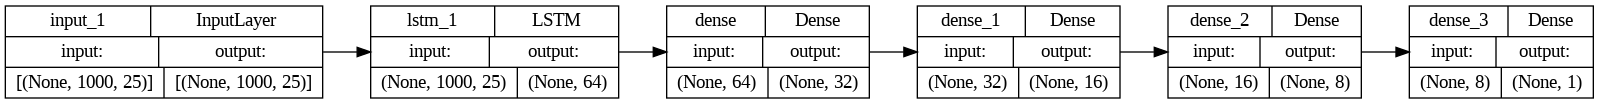

In [8]:
def create_lstm_model(window_size, num_features, hidden_unit):
    inp = tf.keras.Input(shape=(window_size, num_features))

    # LSTM layer
    x = tf.keras.layers.LSTM(hidden_unit, name='lstm_1', return_sequences=False)(inp)

    # Dense layers
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='relu')(x)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='relu')(x)

    model = tf.keras.Model(inputs=inp, outputs=output)

    # Compile the model
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mean_squared_error', 'accuracy'])

    model.summary()

    # Plotting model
    plot = tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

    return model, plot

# Fit and evaluate the network
model, plot = create_lstm_model(window_size, num_features, hidden_unit)
start_time = time.perf_counter()
result = model.fit(X_train_list, y_train, epochs=epochs, batch_size=Batch_Size, verbose=1, shuffle=False, validation_data=(X_test_list, y_test))
end_time = time.perf_counter()
run_time = (end_time - start_time)
print("time = " + str(int(run_time)) + " s = " + str(int(run_time // 60)) + " mins")
plot


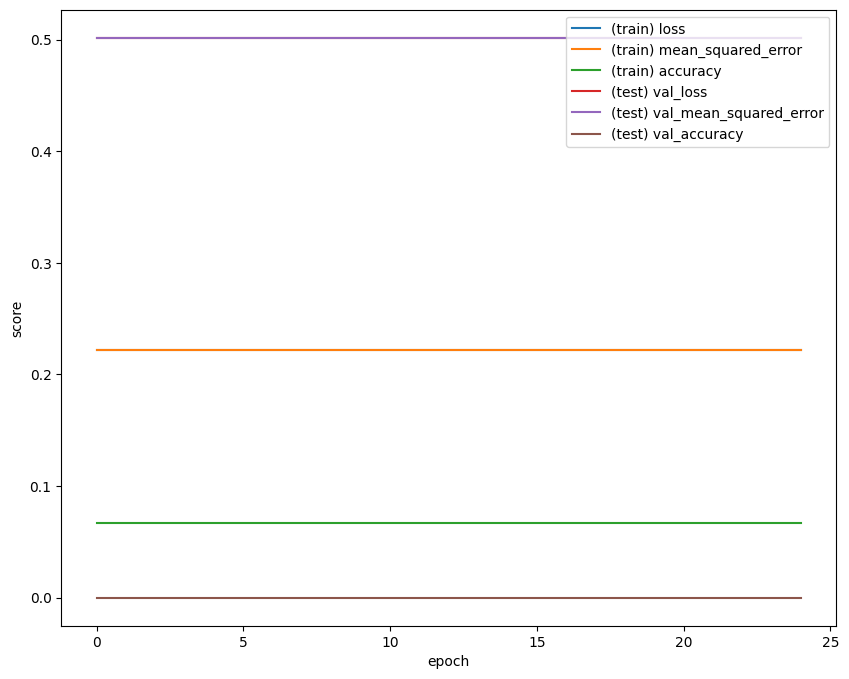

In [9]:
# datafolder = '/content/drive/MyDrive/IntentoCodigo'
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
for key in result.history :
 #if key == "loss" or key == "val_loss": continue
  label = ("(test) " if key.startswith("val_") else "(train) ") + key
  plt.plot(result.history[key], label=label)
#ax.set(ylim=[-0.1, 1.1])no h
ax.set(xlabel="epoch", ylabel="score")
ax.legend()
plt.show()
# fig.savefig(datafolder + "plot-train_test_loss_metrics_LSTM_DL.png")

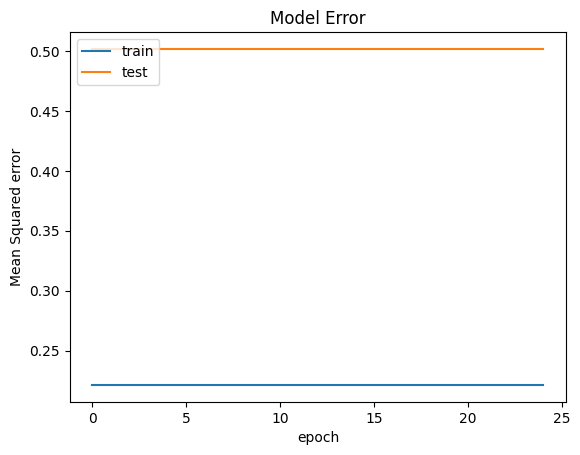

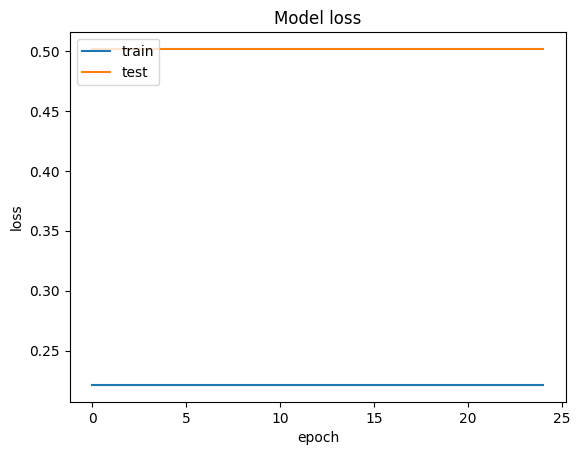

In [10]:
# summarize history for accuracy
plt.plot(result.history['mean_squared_error'])
plt.plot(result.history['val_mean_squared_error'])
plt.title('Model Error')
plt.ylabel('Mean Squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save and load network

In [11]:
# ### Save
# dnn_filename = datafolder + "trained_network_LSTM_DLS6.h5"
# model.save(dnn_filename)
# print("Model saved to: " + dnn_filename)

# ### Load
# model = tf.keras.models.load_model(datafolder + "trained_network_LSTM_DLS6.h5")
# model.summary()

### Evaluate Model with new data (1 Subject)

In [12]:
# ##Loading csv files

path = r'/content/drive/MyDrive/Data Base/Subjects/S7/ S7_106m_outdoor_velocity.CSV'

experiment_df = pd.read_csv(path, skiprows=1, usecols=list(range(4, 29)), names=['Acc_x_knee','Acc_y_knee','Acc_z_knee','Gyro_x_knee','Gyro_y_knee','Gyro_z_knee','Magne_x_knee','Magne_y_knee','Magne_z_knee','Euler_x_knee','Euler_y_knee','Euler_z_knee','Acc_x_hip','Acc_y_hip','Acc_z_hip','Gyro_x_hip','Gyro_y_hip','Gyro_z_hip','Magne_x_hip','Magne_y_hip','Magne_z_hip','Euler_x_hip','Euler_y_hip','Euler_z_hip','Real_Velocity'])
# Let's say you have loaded your new experiment data into a DataFrame called "experiment_df"

# 1. Preprocess the new experiment data
experiment_scaled = scaler.transform(experiment_df)
experiment_sequences_list = []

start_idx = 0
for idx in range(1, len(experiment_df)):
    # Check if it's the end of an experiment
    if experiment_df['Real_Velocity'].iloc[idx] != experiment_df['Real_Velocity'].iloc[idx-1]:
        end_idx = idx
        experiment_sequences_list.append(experiment_scaled[start_idx:end_idx])
        start_idx = idx + 1

# Convert lists to arrays
experiment_sequences = np.array(experiment_sequences_list)
experiment_padded = pad_sequences(experiment_sequences, maxlen=L, padding='post', truncating='post', dtype='float32')
experiment_padded = experiment_padded.reshape((-1, L, num_features))

# 2. Predict with the model
predictions = model.predict(experiment_padded)

# Now, "predictions" will hold the predicted values for your experiment.
print(predictions)

# Assuming "predictions" contains your predicted values

# 1. Create a dummy array with the shape of your original experiment data
# but filled with zeros or any arbitrary values
dummy_array = np.zeros((len(predictions), df_scaled.shape[1]))

# 2. Replace the column corresponding to `Real_Velocity` with your predictions
dummy_array[:, -1] = predictions.flatten()

# 3. Use the `inverse_transform` method to revert the scaling
inverse_transformed_data = scaler.inverse_transform(dummy_array)

# 4. Extract the inverse transformed predictions for `Real_Velocity`
original_predictions = inverse_transformed_data[:, -1]

print("Predictions", original_predictions)


<ipython-input-12-10cbfe0099bf>:5: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  experiment_df = pd.read_csv(path, skiprows=1, usecols=list(range(4, 29)), names=['Acc_x_knee','Acc_y_knee','Acc_z_knee','Gyro_x_knee','Gyro_y_knee','Gyro_z_knee','Magne_x_knee','Magne_y_knee','Magne_z_knee','Euler_x_knee','Euler_y_knee','Euler_z_knee','Acc_x_hip','Acc_y_hip','Acc_z_hip','Gyro_x_hip','Gyro_y_hip','Gyro_z_hip','Magne_x_hip','Magne_y_hip','Magne_z_hip','Euler_x_hip','Euler_y_hip','Euler_z_hip','Real_Velocity'])
<ipython-input-12-10cbfe0099bf>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  experiment_sequences = np.array(experiment_sequences_list)


270/270 [==============================] - 5s 16ms/step
[[nan]
 [ 0.]
 [ 0.]
 ...
 [ 0.]
 [ 0.]
 [ 0.]]
Predictions [  nan 0.007 0.007 ... 0.007 0.007 0.007]


In [13]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# import numpy as np

# path = r'/content/drive/MyDrive/Bases de datos Fase 1 Jennifer y Pilar/S2_30m_regular_velocity_outdoor_RealValue.csv'
# df = pd.read_csv(path, skiprows=1, usecols=list(range(4, 29)), names=['Acc_x_knee','Acc_y_knee','Acc_z_knee','Gyro_x_knee','Gyro_y_knee','Gyro_z_knee','Magne_x_knee','Magne_y_knee','Magne_z_knee','Euler_x_knee','Euler_y_knee','Euler_z_knee','Acc_x_hip','Acc_y_hip','Acc_z_hip','Gyro_x_hip','Gyro_y_hip','Gyro_z_hip','Magne_x_hip','Magne_y_hip','Magne_z_hip','Euler_x_hip','Euler_y_hip','Euler_z_hip','Real_Velocity'])

# original = df['Real_Velocity']

# mask = ~np.isnan(original_predictions)

# original = original[:len(original_predictions)]

# original_filtered = original[mask]
# original_predictions_filtered = original_predictions[mask]

# # 2. Compute the MSE
# mse = mean_squared_error(original_filtered, original_predictions_filtered)

# # Compute the MAE
# mae = mean_absolute_error(original_filtered, original_predictions_filtered)
# print("Mean Absolute Error:", mae)

# # Compute the RMSE
# rmse = np.sqrt(mse)
# print("Root Mean Squared Error:", rmse)

# print("Mean Squared Error:", mse)


In [14]:
# print(dftest.head())
# print(dftest.shape)
# #df.loc[3,"y2"]
# #df.loc[2:4]
# #print(df.loc[2:4])

# dataset_size = dftest.shape[0] ### how many rows
# window_size = 100 ### how many time steps we want to process simultaneously

# xxtest = np.array([ xtest.loc[i:(i+window_size-1)].values for i in range(dataset_size-window_size) ])
# #print(xx[0:5]).loc
# print("shape(xx) = ", xxtest.shape)

# yytest = np.array([ y.loc[i].values for i in range(dataset_size-window_size) ])
# print("shape(yy) = ", yytest.shape)

# #yy = np.array([ y.loc[i:(i+window_size-1)].values for i in range(dataset_size-window_size) ])
# #print(yy[0:5])
# #print("shape(yy) = ", yy.shape)
# #yy[2].shape
# #yy.reshape(-1,2)
# # Preprocess the new dataset

# print(xxtest.shape)
# print(yytest.shape)


# # Evaluate the model on the new dataset
# mse  = model.evaluate(xxtest, yytest, verbose=0)
# print("Mean squared error on new dataset:", mse)

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import metrics

# model = tf.keras.models.load_model("/content/drive/MyDrive/IntentoCodigo/Modelostrained_network_LSTM_DLS6.h5")

# # Supongamos que X_test es la lista de etiquetas reales y y_pred es la lista de predicciones del modelo.
# y_pred = model.predict(xxtest)

# print(y_pred.shape)
# print("Velocity Prediction", y_pred[0:1]*1000)
# #filtered_data = np.where(y_pred < 0.2, 0, y_pred)
# #mask = filtered_data != 0
# #mediciones_filtradas = filtered_data[mask]

# mean_prediction = np.mean(y_pred)
# max = np.max(y_pred)
# min = np.min(y_pred)
# print("Max", max)
# print("Min", min)

# print("Mean of Predictions:", mean_prediction)

# # Cálculo de métricas de regresión
# mse = metrics.mean_squared_error(yytest, y_pred)
# rmse = np.sqrt(mse)
# mae = metrics.mean_absolute_error(yytest, y_pred)
# r2 = metrics.r2_score(yytest, y_pred)


# print("Mean Squared Error: {}".format(mse))
# print("Mean Absolute Error: {}".format(mae))
# print("Root Mean Squared Error: {}".format(rmse))
# print("R-squared: {}".format(r2))



In [16]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Lista de nombres de archivos .csv
# archivos_csv = ['/content/drive/MyDrive/IntentoCodigo/Copia de S9_20m_return_regular velocity.CSV', '/content/drive/MyDrive/IntentoCodigo/Copia de S8_9m_regular_velocity.CSV', '/content/drive/MyDrive/IntentoCodigo/Copia de S8_9m_slow_velocity.CSV', '/content/drive/MyDrive/IntentoCodigo/Copia de S8_18m_return_regular_velocity.CSV', '/content/drive/MyDrive/IntentoCodigo/Copia de S8_60m_outdoor_regular_velocity.CSV']
# # Ajustar los subplots para evitar superposiciones
# plt.tight_layout()

# # Mostrar la figura con las gráficas
# plt.show()

# import pandas as pd
# import matplotlib.pyplot as plt

# # Ruta de tu archivo CSV
# path = '/content/drive/MyDrive/Bases de datos Fase 1 Jennifer y Pilar/Copia de S8_9m_fast_velocity.CSV'

# # Leer el archivo CSV
# df = pd.read_csv(path)


# # # Crear subplots en una figura
# num_subplots = len(df.columns)
# fig, axs = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

# # # Crear un DataFrame consolidado
# datos_consolidados = pd.concat([pd.read_csv(path) for archivo in df])

# # # Recorrer los archivos y crear las gráficas en los subplots
# # for i, archivo in enumerate(archivos_csv):
# #     datos = pd.read_csv(archivo)
# #     axs[i].plot(datos[' Euler_y_hip'], label='Euler_y_hip')
# #     axs[i].set_xlabel('Muestras')
# #     axs[i].set_ylabel('Valores')
# #     axs[i].set_title(f'Gráficas para {archivo}')
# #     axs[i].legend()



# # Crear un gráfico de líneas para todas las columnas
# plt.figure(figsize=(10, 6))
# for columna in df.columns:
#     plt.plot(df[columna], label=columna)

# # Configurar etiquetas y título
# plt.xlabel('Muestras')
# plt.ylabel('Valores')
# plt.title('Gráfico de Todas las Columnas')
# plt.legend()

# # Mostrar el gráfico
# plt.show()

#import pandas as pd
#import matplotlib.pyplot as plt

# Ruta de tu archivo CSV
#path = '/content/drive/MyDrive/IntentoCodigo/Copia de S8_9m_fast_velocity.CSV'

# Leer el archivo CSV
#df= pd.read_csv(path, skiprows=1, usecols=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], names=['Acc_x_knee','Acc_y_knee','Acc_z_knee','Gyro_x_knee','Gyro_y_knee','Gyro_z_knee','Magne_x_knee','Magne_y_knee','Magne_z_knee','Euler_x_knee','Euler_y_knee','Euler_z_knee','Acc_x_hip','Acc_y_hip','Acc_z_hip','Gyro_x_hip','Gyro_y_hip','Gyro_z_hip','Magne_x_hip','Magne_y_hip','Magne_z_hip','Euler_x_hip','Euler_y_hip','Euler_z_hip'])

# Obtener el número de columnas y filas para la disposición de los subplots
#num_cols = 6  # Número de columnas en la disposición
#num_filas = (df.shape[1] + num_cols - 1) // num_cols  # Calcular el número de filas necesario

# Crear subplots con la disposición deseada
#fig, axs = plt.subplots(num_filas, num_cols, figsize=(15, 10))

# Iterar a través de las columnas y trazar cada una en un subplot
#for i, columna in enumerate(df.columns):
   # fila_actual = i // num_cols
    #columna_actual = i % num_cols
    #axs[fila_actual, columna_actual].plot(df[columna])
    #axs[fila_actual, columna_actual].set_title(columna)
    #axs[fila_actual, columna_actual].set_xlabel('Muestras')
    #axs[fila_actual, columna_actual].set_ylabel('Valores')

# Eliminar subplots vacíos si es necesario
#for i in range(len(df.columns), num_filas * num_cols):
  #  fila_actual = i // num_cols
    #columna_actual = i % num_cols
    #fig.delaxes(axs[fila_actual, columna_actual])

# Ajustar el diseño de los subplots
#plt.tight_layout()

# Mostrar los subplots
#plt.show()
